In [1]:

import os,sys,glob
# Move two levels up work from project level, not location of analysis file
os.chdir('../..')
print(os.getcwd())
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import Functions.globalFunctions.ExtracellularField as EcF
from matplotlib import cm
from typing import Literal
from scipy import integrate
import ipympl
import time
#import warnings
from Analyses.SDC_singlePulse_fixedIntensity.tools import *
from Analyses.SDC_singlePulse_fixedIntensity import loader
#warnings.filterwarnings('error',category=UserWarning)

%matplotlib inline
recollect = False


d:\Users\rschoete\Documents\Optogenetics\OptogeneticExcitability\Code


In [2]:
#Load data
filepath = './Results/SDC/SDC_constI'


# list parameters of interest
cell_init_options = ['phi_0', 'theta_0', 'psi_0', 'neurontemplate']
settings_options = ['seed', 'celsius', 'dt']
opsin_options = ['Gmax', 'distribution', 'opsinmech',
                    'distribution_method', 'opsinlocations']
field_options = ['field', 'nPulse']
result = ['amp', 'sR', 'ichr2', 'gchr2', 'dur']
all_columns = result+field_options+opsin_options+cell_init_options+settings_options

# opsinlocations to single word
opsinLocation_map = loader.opsinLocation_map
master_df = loader.load_data_df(filepath = filepath, filename = 'all_data.csv', recollect = recollect, result = result, all_columns = all_columns, cell_init_options  = cell_init_options, settings_options  = settings_options, opsin_options = opsin_options, field_options = field_options, fill_missing_xyzpositions = True, save_recollect = True, savename = None)
master_df['amp'] = master_df['amp']/1000 # convert W/m2 -> mW/mm2
master_df['TAC']=-master_df['ichr2']/master_df['dur']
master_df['Gmax'] = np.round(master_df['Gmax'],4)
unique_values_columns_master = {key: master_df[key].unique() for key in all_columns}
master_df.head()


,amp,sR,ichr2,gchr2,dur,field,nPulse,Gmax,distribution,opsinmech,distribution_method,opsinlocations,phi_0,theta_0,psi_0,neurontemplate,seed,celsius,dt,TAC
0,NaN,NaN,-79.8229,0.02321,0.1,constant,1,0.1,distribution = lambda x: 1,chr2h134r,3d,alldend,0,-1.570796,0,CA1_PC_cAC_sig5,1.638360e+09,34,0.025,798.229000
1,NaN,NaN,-294.2680,0.08692,1.0,constant,1,0.1,distribution = lambda x: 1,chr2h134r,3d,alldend,0,-1.570796,0,CA1_PC_cAC_sig5,1.638360e+09,34,0.025,294.268000
2,NaN,NaN,-378.4174,0.11240,10.0,constant,1,0.1,distribution = lambda x: 1,chr2h134r,3d,alldend,0,-1.570796,0,CA1_PC_cAC_sig5,1.638360e+09,34,0.025,37.841740
3,NaN,NaN,-826.1007,0.24430,100.0,constant,1,0.1,distribution = lambda x: 1,chr2h134r,3d,alldend,0,-1.570796,0,CA1_PC_cAC_sig5,1.638360e+09,34,0.025,8.261007
4,NaN,NaN,-4397.2577,1.28650,1000.0,constant,1,0.1,distribution = lambda x: 1,chr2h134r,3d,alldend,0,-1.570796,0,CA1_PC_cAC_sig5,1.638360e+09,34,0.025,4.397258


In [3]:
#test selector
myselection = {key:unique_values_columns_master[key][0] for key in [*cell_init_options,*settings_options,*opsin_options,*field_options]}
myselection['dur'] = 100
myselection['Gmax'] = 1
intm_df = master_df[selection_generator(master_df,unique_values_columns_master,verbose=False,**myselection)].reset_index(drop=True)
intm_df.head(len(intm_df))


,amp,sR,ichr2,gchr2,dur,field,nPulse,Gmax,distribution,opsinmech,distribution_method,opsinlocations,phi_0,theta_0,psi_0,neurontemplate,seed,celsius,dt,TAC
0,0.059784,1.0,-3760.7993,1.1109,100.0,constant,1,1.0,distribution = lambda x: 1,chr2h134r,3d,alldend,0,-1.570796,0,CA1_PC_cAC_sig5,1.638360e+09,34,0.025,37.607993


[array(['alldend', 'allsec', 'apic', 'axon', 'basaldend', 'soma'],
      dtype=object), array(['CA1_PC_cAC_sig5', 'CA1_PC_cAC_sig6', 'cNACnoljp1', 'cNACnoljp2'],
      dtype=object)]






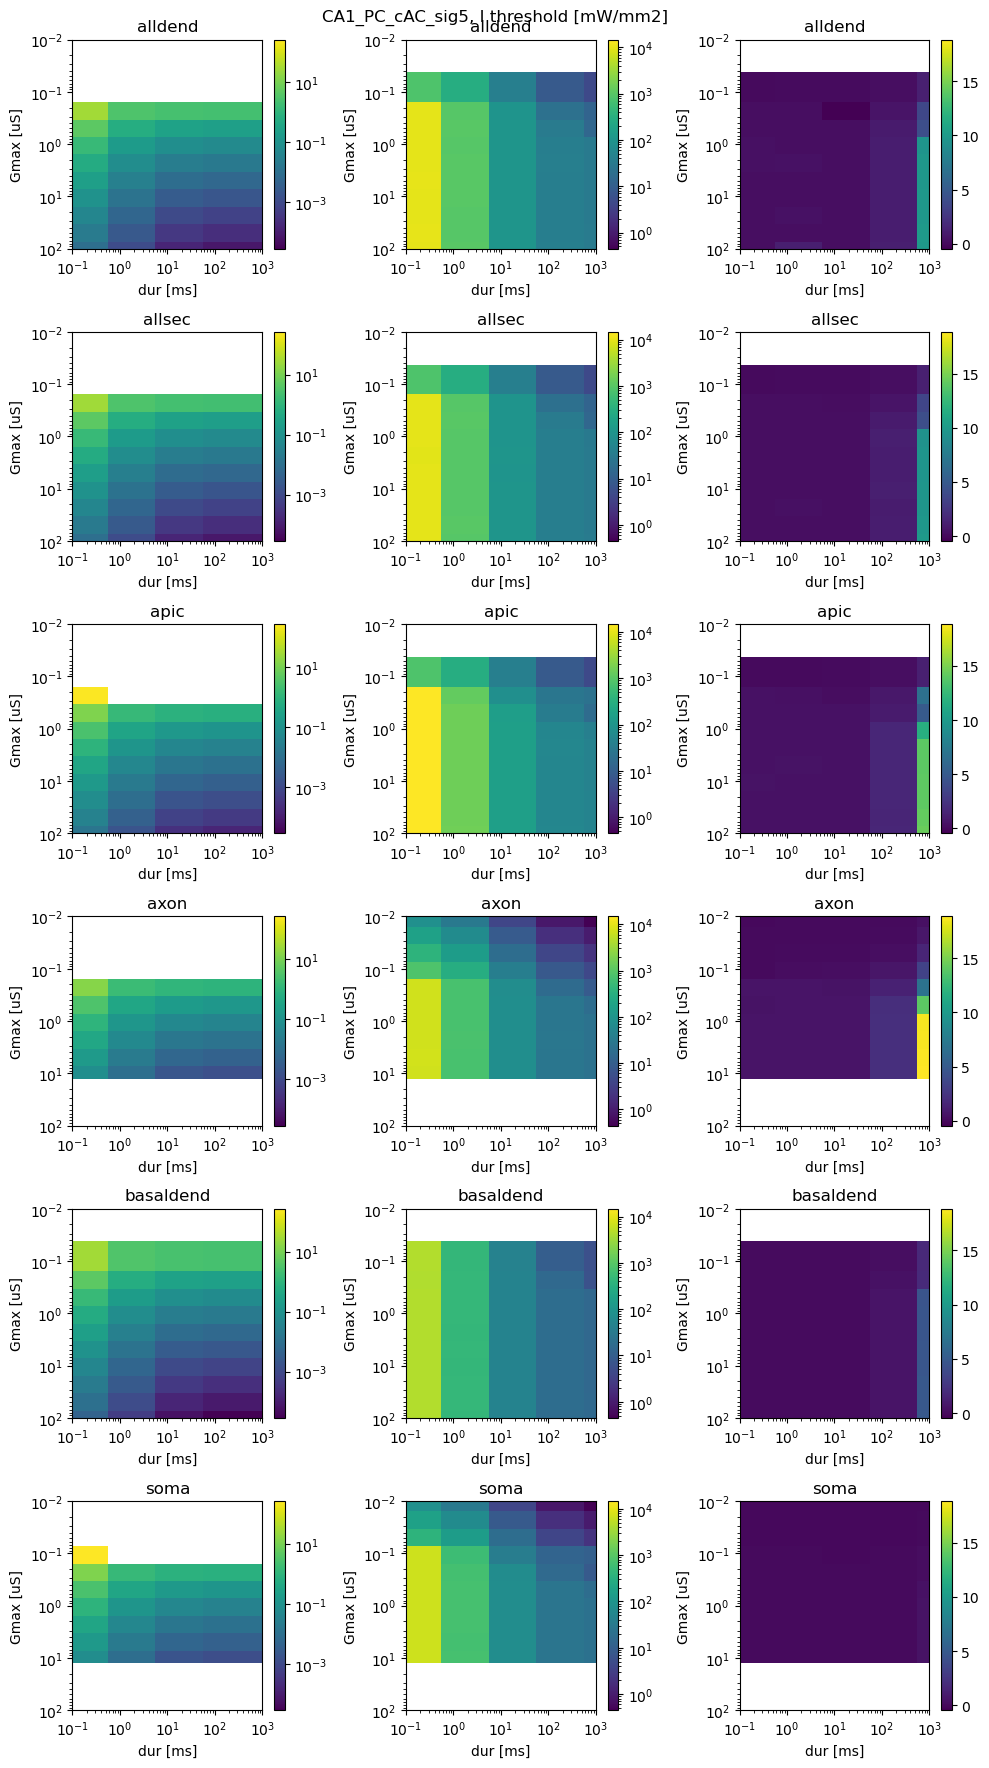

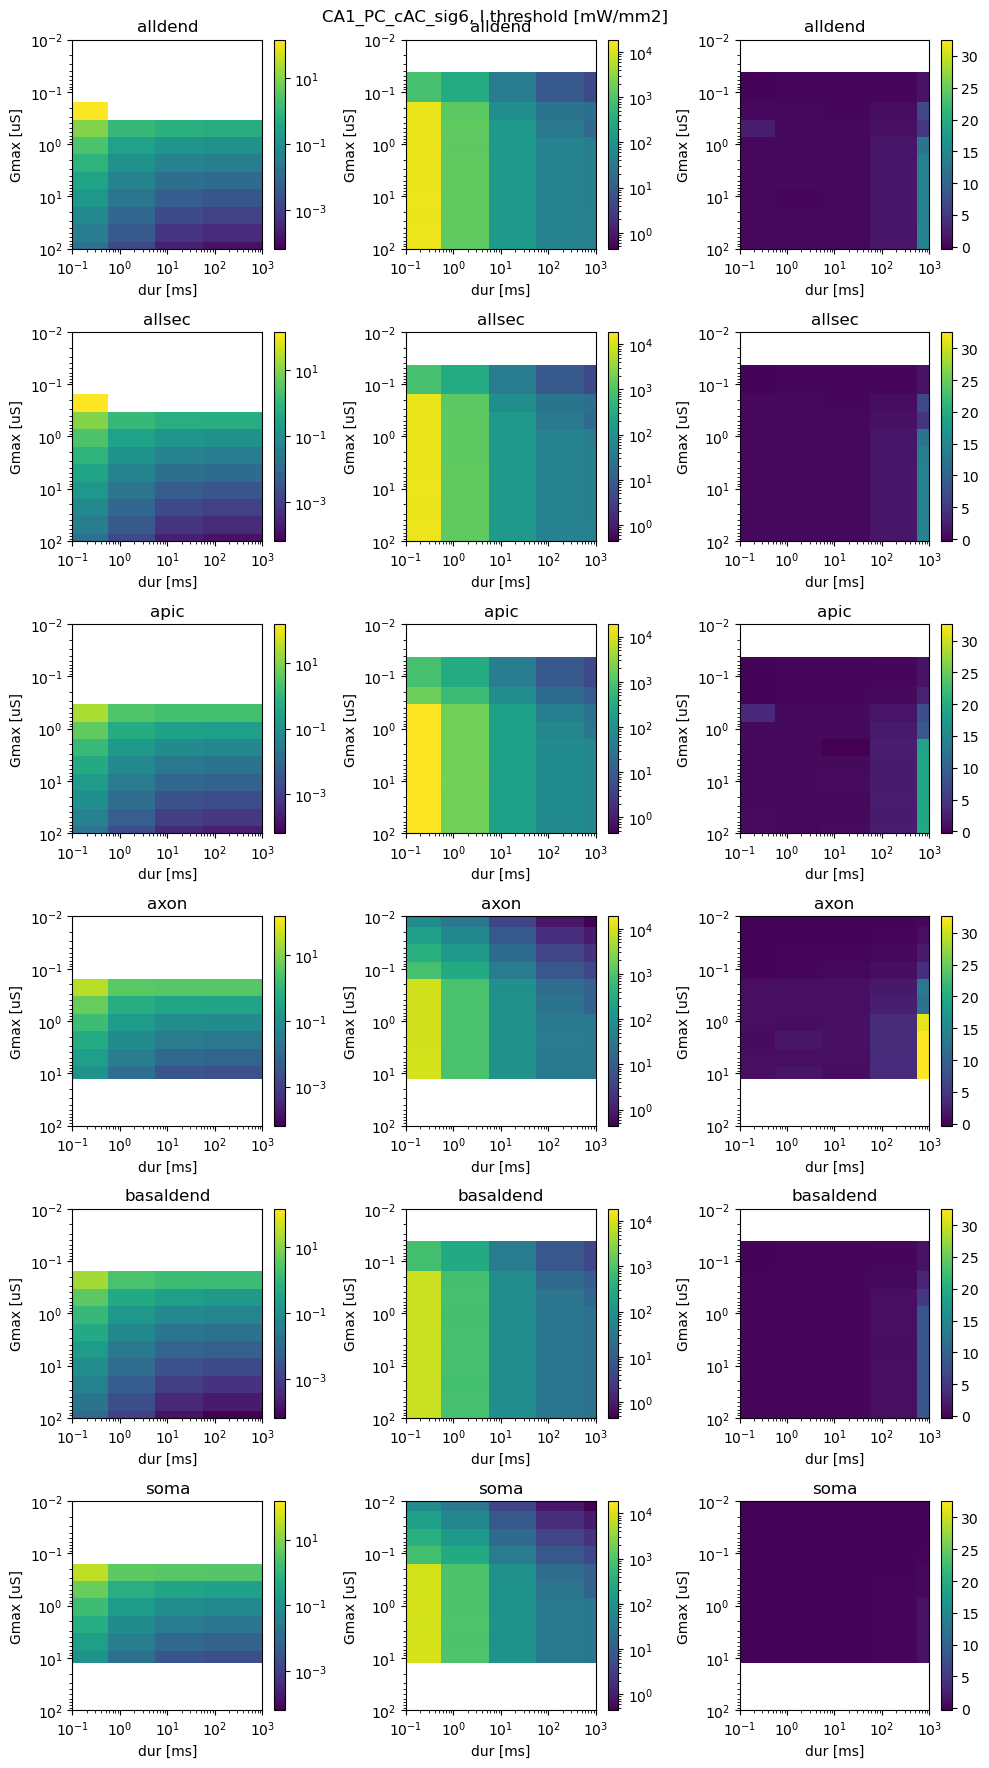

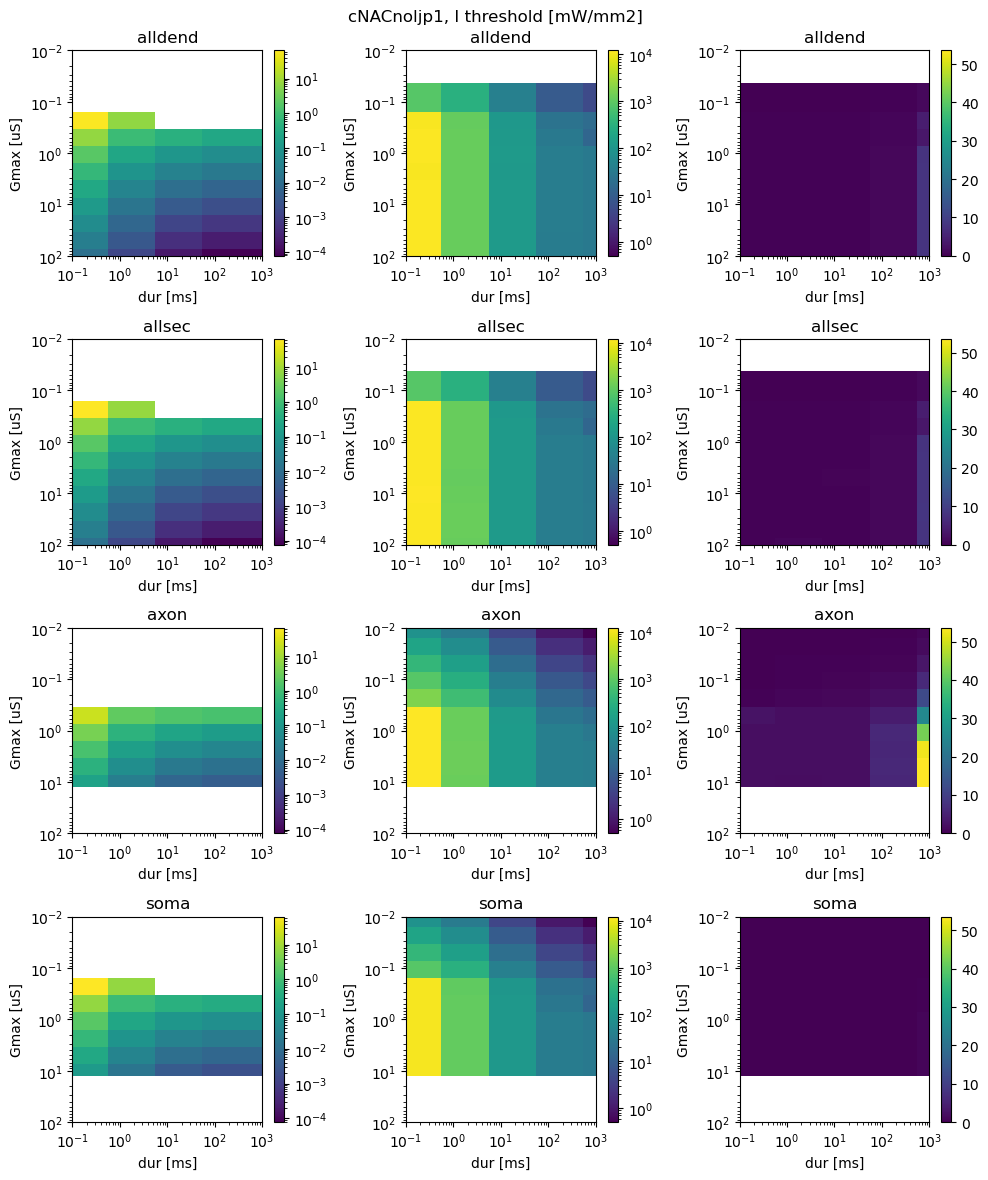

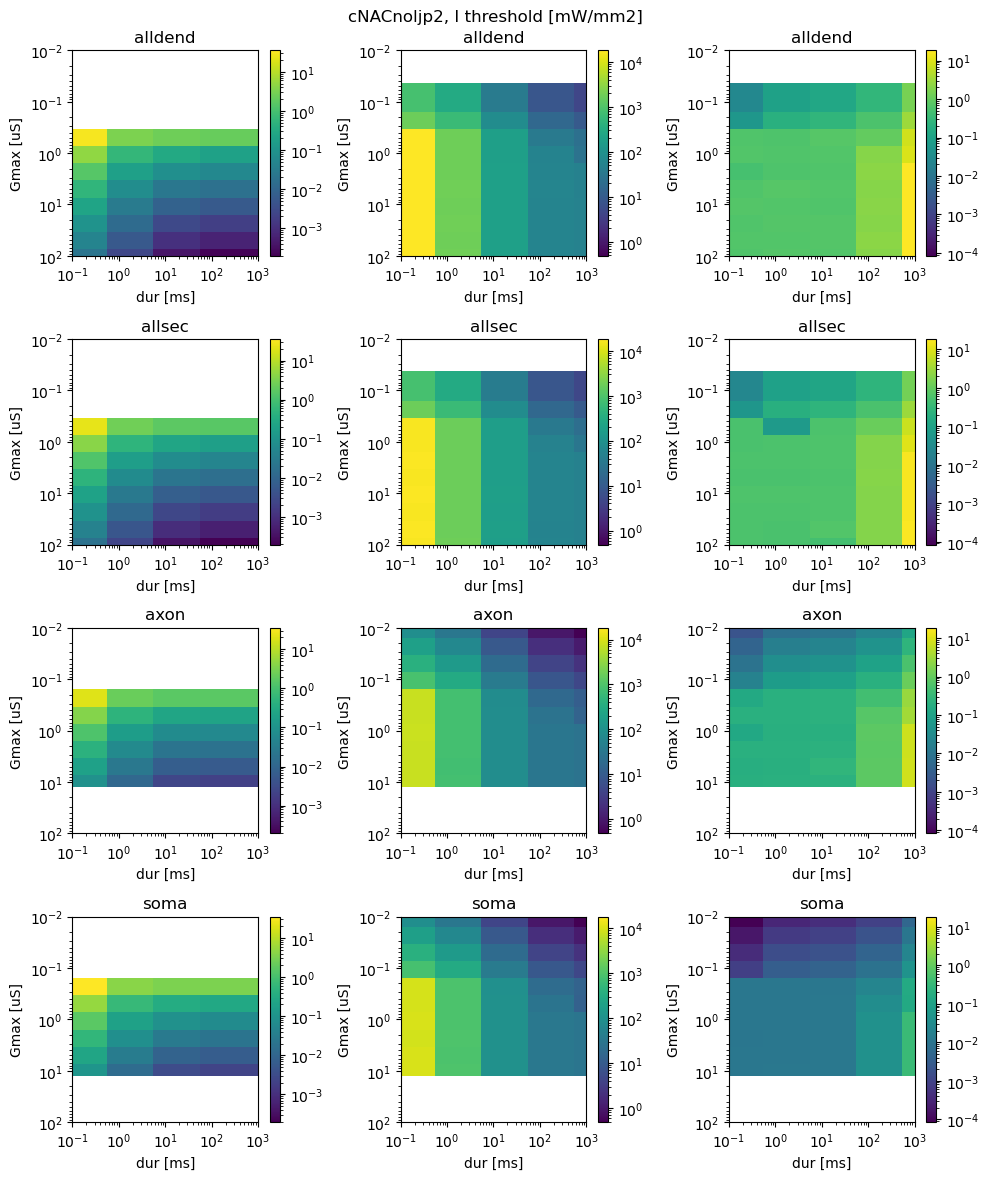

In [4]:
variables = ['opsinlocations','neurontemplate']
print([unique_values_columns_master[key] for key in variables])
levels = [0.1,1,10]
norm_log_cntr = cm.colors.LogNorm(vmax=levels[-1]*10, vmin=levels[0])
for neurontemplate in unique_values_columns_master['neurontemplate']:
    fig_df = master_df[selection_generator(master_df,unique_values_columns=unique_values_columns_master,neurontemplate=neurontemplate)]
    uOpsinLocations = fig_df['opsinlocations'].unique()
    fig,axs = plt.subplots(len(uOpsinLocations),3,tight_layout = True,figsize = (10,3*len(uOpsinLocations)))
    for i,datalabel in enumerate(['amp','TAC', 'gchr2']):
        Imin = np.min(fig_df[datalabel])
        Imax = np.max(fig_df[datalabel])
        if Imin<0:
            norm = cm.colors.Normalize(vmax=Imax, vmin=Imin)
        else:
            norm = cm.colors.LogNorm(vmax=Imax, vmin=Imin)
        for oL,ax in zip(uOpsinLocations,axs[:,i]):
            intm_df = fig_df[fig_df['opsinlocations']==oL]
            data_toplot = EcF.prepareDataforInterp(np.array((intm_df['dur'],intm_df['Gmax'],intm_df[datalabel])).T,'ninterp')
            yY, zZ = np.meshgrid(list(intm_df['dur'].unique()),list(intm_df['Gmax'].unique()))

            im,cb = EcF.slicePlot(data_toplot,ax,fig,plotGrid=(yY,zZ),structured=True, norm=norm)
            ax.set_xscale('log')
            ax.set_xlim((min(intm_df['dur'].unique()),max(intm_df['dur'].unique())))
            ax.set_yscale('log')
            ax.set_ylim((1e-2,1e2))
            ax.invert_yaxis()
            ax.set_xlabel('dur [ms]')
            ax.set_ylabel('Gmax [uS]')
            ax.set_title(f'{oL}')
    fig.suptitle(f'{neurontemplate}, I threshold [mW/mm2]')
    print()

In [ ]:
unique_values_columns_master['opsinlocations']

array(['alldend', 'allsec', 'apic', 'axon', 'basaldend', 'soma'],
      dtype=object)

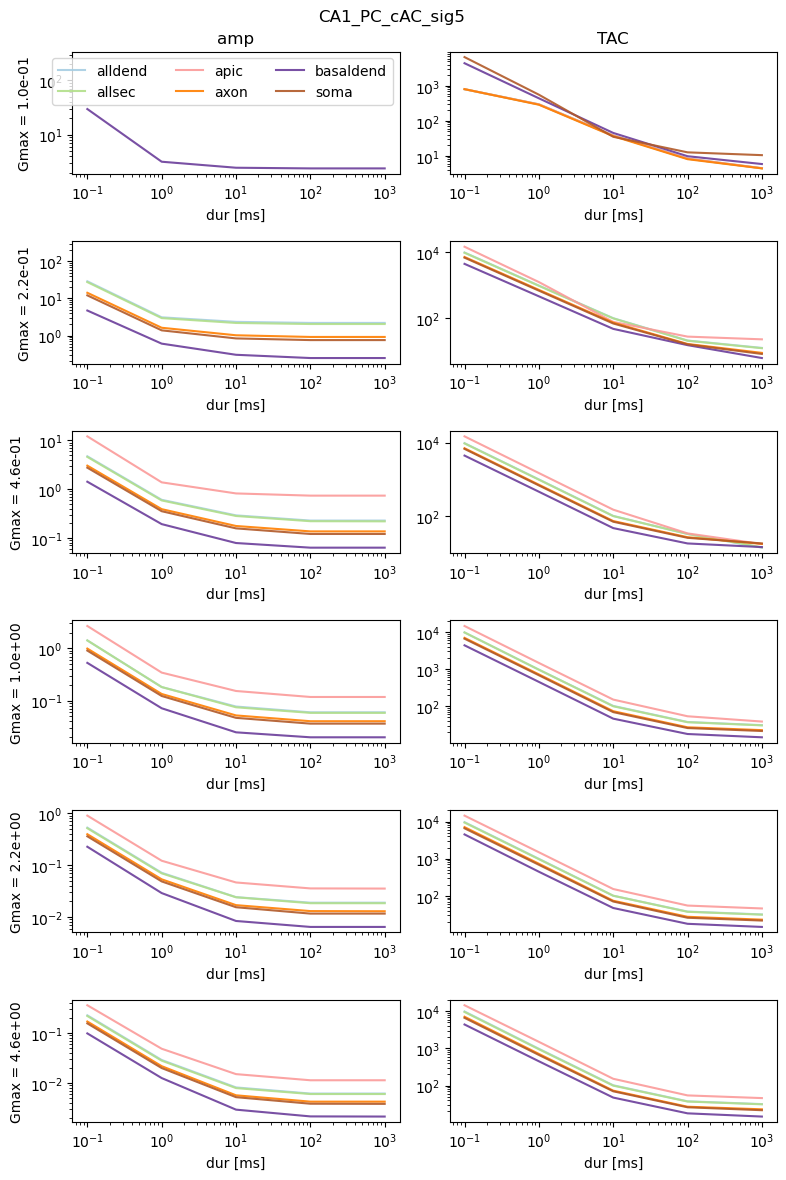

In [5]:
reference = ''
colors = plt.get_cmap('Paired',len(unique_values_columns_master['opsinlocations'])).colors
colorpairs = {x:clr for x,clr in zip(unique_values_columns_master['opsinlocations'],colors)}
linestyle_str = ['solid', 'dotted', 'dashed', 'dashdot']
uGmax = np.sort(master_df['Gmax'].unique())[3:-4]
fig,axs = plt.subplots(len(uGmax),2,tight_layout = True,figsize = (8,2*len(uGmax)))
for neurontemplate,linestyle in zip(unique_values_columns_master['neurontemplate'][:1],linestyle_str):
    fig_df = master_df[selection_generator(master_df,unique_values_columns=unique_values_columns_master,neurontemplate=neurontemplate)]
    uGmax = np.sort(fig_df['Gmax'].unique())[3:-4]
    for i,datalabel in enumerate(['amp','TAC']):
        for uG,ax in zip(uGmax,axs[:,i]):
            logscale = False
            intm_df = fig_df[fig_df['Gmax']==uG]
            uOpsinLocations = [x for x in intm_df['opsinlocations'].unique() if x != reference]
            for oL in uOpsinLocations:
                clr = colorpairs[oL]
                plot_df = intm_df[intm_df['opsinlocations']==oL]
                xdata = plot_df['dur']
                ydata = plot_df[datalabel]
                ref_ydata = intm_df[intm_df['opsinlocations']==reference][datalabel]
                ax.plot(xdata,ydata,color=clr,alpha=0.9,linestyle=linestyle,label=oL)
                if sum(~ np.isnan(ydata))>0:
                    logscale = True
            if logscale:
                ax.set_xscale('log')
                ax.set_yscale('log')
            ax.set_xlabel('dur [ms]')
            if i==0:
                ax.set_ylabel(f'Gmax = {uG:0.1e}')
            if uG == uGmax[0]:
                ax.set_title(datalabel)
                if i==0:
                    ax.legend(ncol=3)


    fig.suptitle(f'{neurontemplate}')
    print()

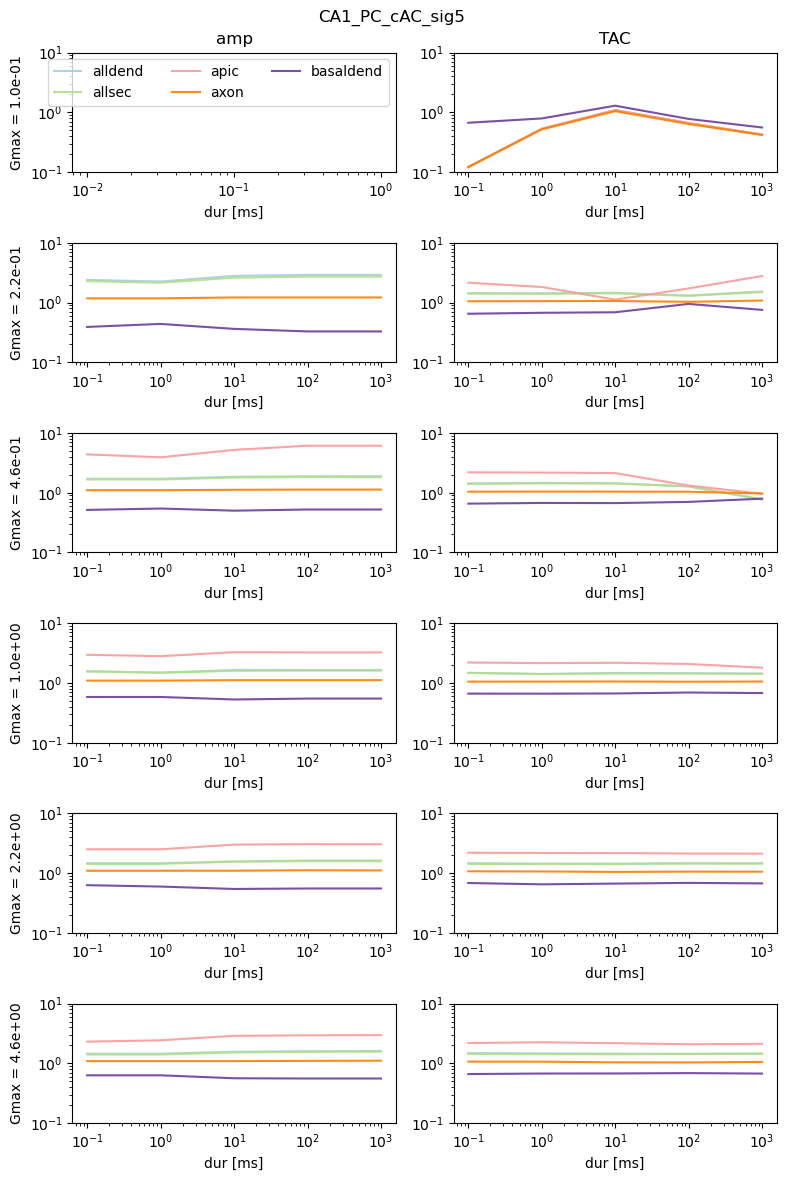

In [6]:
reference = 'soma'
colors = plt.get_cmap('Paired',len(unique_values_columns_master['opsinlocations'])).colors
colorpairs = {x:clr for x,clr in zip(unique_values_columns_master['opsinlocations'],colors)}
linestyle_str = ['solid', 'dotted', 'dashed', 'dashdot']
uGmax = np.sort(master_df['Gmax'].unique())[3:-4]
fig,axs = plt.subplots(len(uGmax),2,tight_layout = True,figsize = (8,2*len(uGmax)))
for neurontemplate,linestyle,alpha in zip(unique_values_columns_master['neurontemplate'][:1],linestyle_str,[0.9,0.7]):
    fig_df = master_df[selection_generator(master_df,unique_values_columns=unique_values_columns_master,neurontemplate=neurontemplate)]


    for i,datalabel in enumerate(['amp','TAC']):
        for uG,ax in zip(uGmax,axs[:,i]):
            logscale = False
            intm_df = fig_df[fig_df['Gmax']==uG]
            uOpsinLocations = [x for x in intm_df['opsinlocations'].unique() if x != reference]
            for oL in uOpsinLocations:
                clr = colorpairs[oL]
                plot_df = intm_df[intm_df['opsinlocations']==oL]
                xdata = plot_df['dur']
                ydata = plot_df[datalabel]
                ref_ydata = intm_df[intm_df['opsinlocations']==reference][datalabel]
                if len(ydata)==len(ref_ydata):
                    ydata = np.array(ydata)/np.array(ref_ydata)
                    ax.plot(xdata,ydata,color=clr,alpha=alpha,linestyle=linestyle,label=oL)
                    if sum(~ np.isnan(ydata))>0:
                        logscale = True
            if logscale:
                ax.set_xscale('log')
                ax.set_yscale('log')
                ax.set_ylim([0.1,10])
            ax.set_xlabel('dur [ms]')
            if i==0:
                ax.set_ylabel(f'Gmax = {uG:0.1e}')
            if uG == uGmax[0]:
                ax.set_title(datalabel)
                if i==0:
                    ax.legend(ncol=3)


    fig.suptitle(f'{neurontemplate}')
    print()

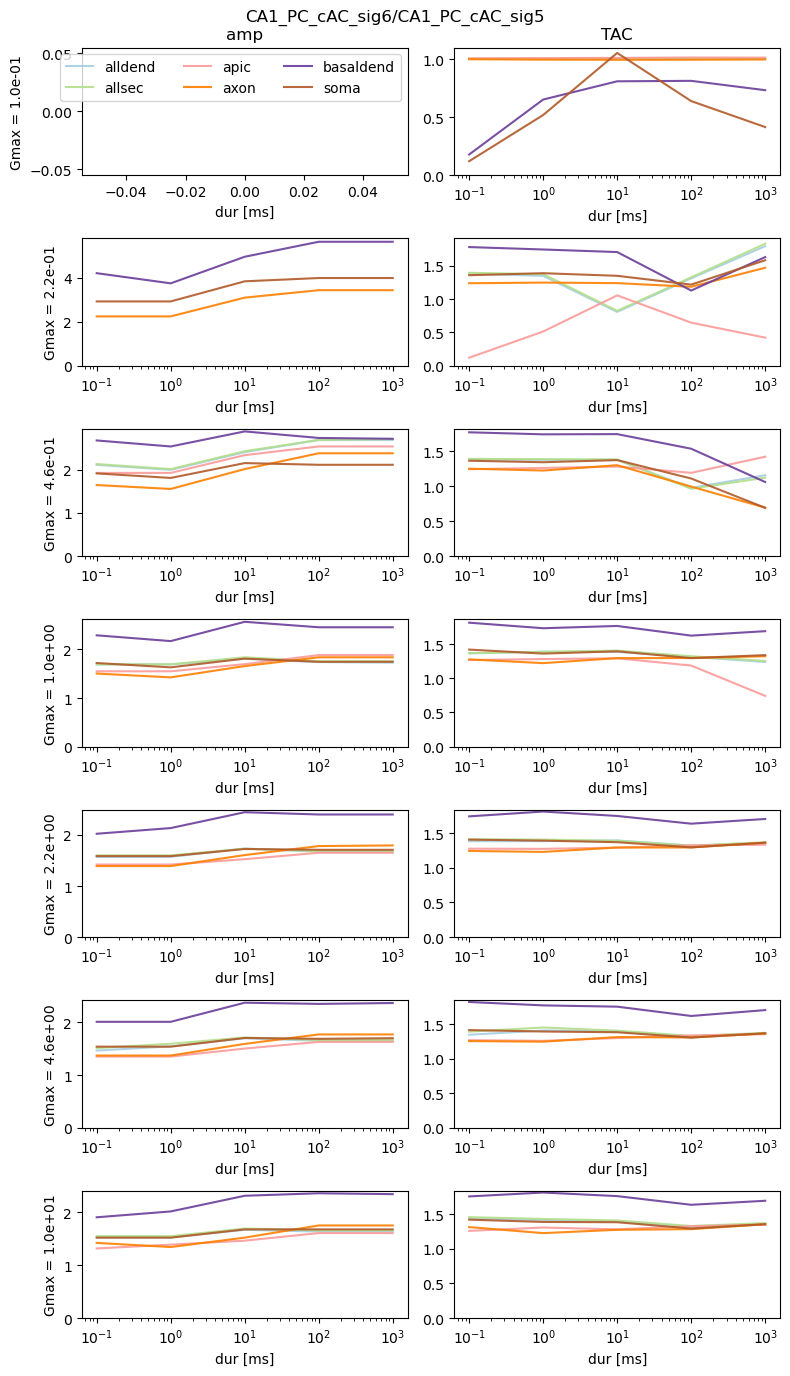

In [10]:
variables = unique_values_columns_master['neurontemplate'][:2]
colors = plt.get_cmap('Paired',len(unique_values_columns_master['opsinlocations'])).colors
colorpairs = {x:clr for x,clr in zip(unique_values_columns_master['opsinlocations'],colors)}
linestyle_str = ['solid', 'dotted', 'dashed', 'dashdot']
uGmax = np.sort(master_df['Gmax'].unique())[3:-3]
fig,axs = plt.subplots(len(uGmax),2,tight_layout = True,figsize = (8,2*len(uGmax)))


cell_diff_dict = {}
uOpsinLocations = list(master_df[master_df['neurontemplate']==variables[1]]['opsinlocations'].unique())
cell_diff_dict['pyr'] = {key:{'amp':[],'TAC':[],'Gmax':[],'durs':[]} for key in uOpsinLocations}
for i,datalabel in enumerate(['amp','TAC']):
    uOpsinLocations = list(master_df[master_df['neurontemplate']==variables[1]]['opsinlocations'].unique())
    for oL in uOpsinLocations:
        for uG,ax in zip(uGmax,axs[:,i]):
            logscale = False
            intm_df = master_df[master_df['Gmax']==uG]

            clr = colorpairs[oL]
            plot_df = intm_df[intm_df['opsinlocations']==oL]
            xdata = plot_df['dur'][plot_df['neurontemplate']==variables[1]]
            ydata = plot_df[datalabel][plot_df['neurontemplate']==variables[1]]
            ref_ydata = plot_df[datalabel][plot_df['neurontemplate']==variables[0]]
            if len(ydata)==len(ref_ydata):
                ydata = np.array(ydata)/np.array(ref_ydata)
                ax.plot(xdata,ydata,color=clr,alpha=0.9,label=oL)
                if sum(~ np.isnan(ydata))>0:
                    logscale = True
            if logscale:
                ax.set_xscale('log')
                #ax.set_yscale('log')
                if oL==uOpsinLocations[-1]:
                    ax.set_ylim([0,ax.get_ylim()[1]])
            ax.set_xlabel('dur [ms]')
            if i==0:
                ax.set_ylabel(f'Gmax = {uG:0.1e}')
            if uG == uGmax[0]:
                ax.set_title(datalabel)
                if i==0:
                    ax.legend(ncol=3)


    fig.suptitle(f'{variables[1]}/{variables[0]}')
    print()

In [ ]:
df1 = master_df[master_df['opsinlocations']=='soma']
df2 = master_df[master_df['opsinlocations']!='soma']
df1 = df1.set_index(['neurontemplate','dur','Gmax'])[['amp','sR','TAC','gchr2']]
df2 = df2.set_index(['neurontemplate','dur','Gmax','opsinlocations'])[['amp','sR','TAC','gchr2']]
rel_df = pd.merge(df1, df2, left_index=True, right_index = True, suffixes=('_0', '_1'),validate='one_to_many')
for key in ['amp','TAC','gchr2']:
    #df3['diff_'+key] = df3[key+'_1']-df3[key+'_0']
    rel_df['ratio_'+key] = rel_df[key+'_1']/rel_df[key+'_0']
rel_df.reset_index(inplace=True)
columns = ['ratio_amp','ratio_TAC','ratio_gchr2']#['diff_amp','ratio_amp','diff_ichr2','ratio_ichr2','diff_gchr2','ratio_gchr2']
grouped = rel_df.groupby('neurontemplate')[columns]
overall_rel_df = pd.merge(grouped.mean(),grouped.std(),left_index=True, right_index=True, suffixes=('_mean', '_std'))
overall_rel_df

In [11]:
df1 = master_df[master_df['neurontemplate']==unique_values_columns_master['neurontemplate'][0]]
df2 = master_df[master_df['neurontemplate']==unique_values_columns_master['neurontemplate'][1]]
df1 = df1.set_index(['opsinlocations','dur','Gmax'])[['amp','sR','TAC','gchr2']]
df2 = df2.set_index(['opsinlocations','dur','Gmax'])[['amp','sR','TAC','gchr2']]
pyr_df = pd.merge(df1, df2, left_index=True, right_index=True, suffixes=('_0', '_1'))
for key in ['amp','TAC','gchr2']:
    #df3['diff_'+key] = df3[key+'_1']-df3[key+'_0']
    pyr_df['ratio_'+key] = pyr_df[key+'_1']/pyr_df[key+'_0']
pyr_df.reset_index(inplace=True)
columns = ['ratio_amp','ratio_TAC','ratio_gchr2']#['diff_amp','ratio_amp','diff_ichr2','ratio_ichr2','diff_gchr2','ratio_gchr2']
grouped = pyr_df.groupby('opsinlocations')[columns]
overall_pyr_df = pd.merge(grouped.mean(),grouped.std(),left_index=True, right_index=True, suffixes=('_mean', '_std'))
overall_pyr_df



,ratio_amp_mean,ratio_TAC_mean,ratio_gchr2_mean,ratio_amp_std,ratio_TAC_std,ratio_gchr2_std
opsinlocations,,,,,,
alldend,1.788940,1.316510,1.451094,0.609824,0.162639,1.087553
allsec,1.807495,1.327614,1.451646,0.607509,0.168911,0.226247
apic,1.600870,1.179573,1.273732,0.307034,0.261721,1.018476
axon,1.876362,1.151964,1.497693,0.570488,0.161644,0.333351
basaldend,2.558635,1.588870,1.667671,0.883518,0.357410,0.387169
soma,2.031525,1.155980,2.007117,0.727843,0.295897,0.558765


In [12]:
grouped = pyr_df.groupby(['opsinlocations','dur'])[columns]
dur_pyr_df = pd.merge(grouped.mean(),grouped.std(),left_index=True, right_index=True, suffixes=('_mean', '_std'))
dur_pyr_df

ratio_amp_mean  ratio_TAC_mean  ratio_gchr2_mean  \
opsinlocations dur                                                        
alldend        0.1           1.984720        1.346484          2.065650   
               1.0           1.606383        1.357321          1.173039   
               10.0          1.770386        1.294766          1.255126   
               100.0         1.779414        1.249808          1.366384   
               1000.0        1.779321        1.334171          1.395271   
allsec         0.1           2.007213        1.366135          1.572668   
               1.0           1.619954        1.367630          1.478241   
               10.0          1.789073        1.304950          1.438371   
               100.0         1.797676        1.257820          1.354514   
               1000.0        1.798595        1.341536          1.414434   
apic           0.1           1.438896        1.128674          1.816068   
               1.0           1.438269        1.161599          1.094026   
               10.0          1.609958        1.241910          1.022019   
               100.0         1.757944        1.199611          1.253386   
               1000.0        1.759285        1.166074          1.183162   
axon           0.1           1.594898        1.157835          1.449703   
               1.0           1.553811        1.139151          1.668012   
               10.0          1.913675        1.170712          1.461199   
               100.0         2.158662        1.135445          1.442848   
               1000.0        2.160766        1.156680          1.466703   
basaldend      0.1           2.302982        1.613778          1.699190   
               1.0           2.274260        1.657433          1.763064   
               10.0          2.685205        1.656653          1.745802   
               100.0         2.766353        1.488515          1.554088   
               1000.0        2.764374        1.527972          1.576210   
soma           0.1           1.866366        1.149291          2.035408   
               1.0           1.833915        1.177544          2.043119   
               10.0          2.150463        1.229751          2.127182   
               100.0         2.152442        1.113917          1.938096   
               1000.0        2.154438        1.109397          1.891779   

                       ratio_amp_std  ratio_TAC_std  ratio_gchr2_std  
opsinlocations dur                                                    
alldend        0.1          1.205545       0.124057         2.279221  
               1.0          0.171906       0.127442         0.410259  
               10.0         0.267525       0.210084         0.663045  
               100.0        0.371101       0.136754         0.170373  
               1000.0       0.370528       0.202189         0.219225  
allsec         0.1          1.199172       0.130908         0.248556  
               1.0          0.174699       0.130790         0.225826  
               10.0         0.268623       0.210402         0.229722  
               100.0        0.364222       0.144448         0.166601  
               1000.0       0.371624       0.215246         0.236867  
apic           0.1          0.214527       0.364300         2.134516  
               1.0          0.217869       0.242534         0.278341  
               10.0         0.306981       0.110576         0.617955  
               100.0        0.332342       0.220126         0.257089  
               1000.0       0.331465       0.335423         0.351042  
axon           0.1          0.330051       0.137551         0.228012  
               1.0          0.342648       0.121697         0.555294  
               10.0         0.601623       0.150500         0.209684  
               100.0        0.665937       0.148958         0.227325  
               1000.0       0.664532       0.250495         0.329145  
basaldend      0.1          0.759414       0.505141         

Text(0.5, 0.98, 'opsin in section x/opsin in soma')

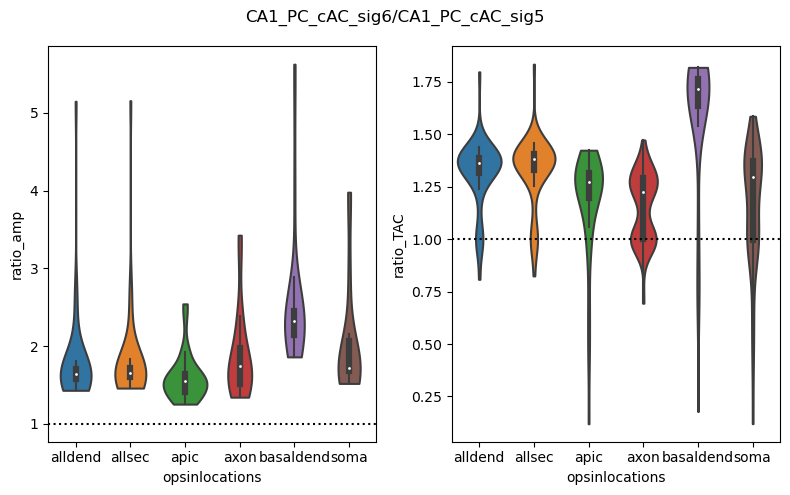

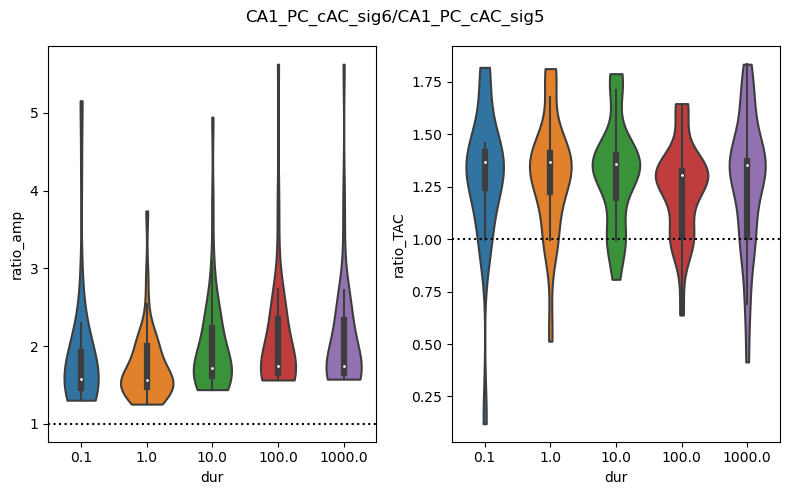

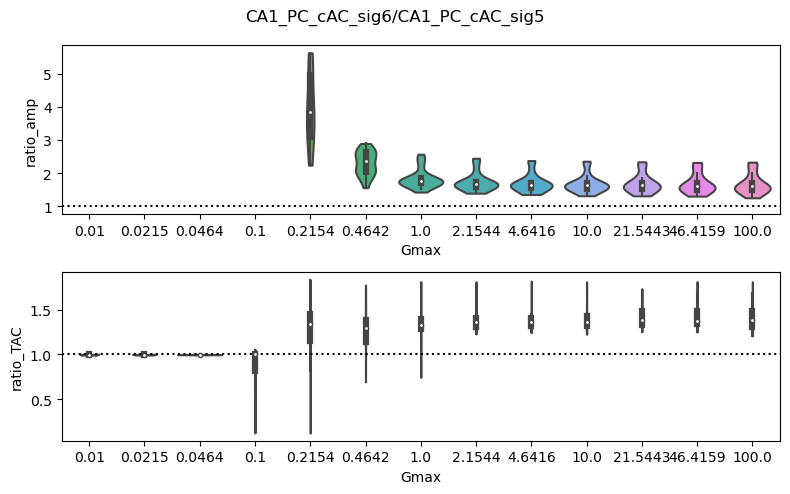

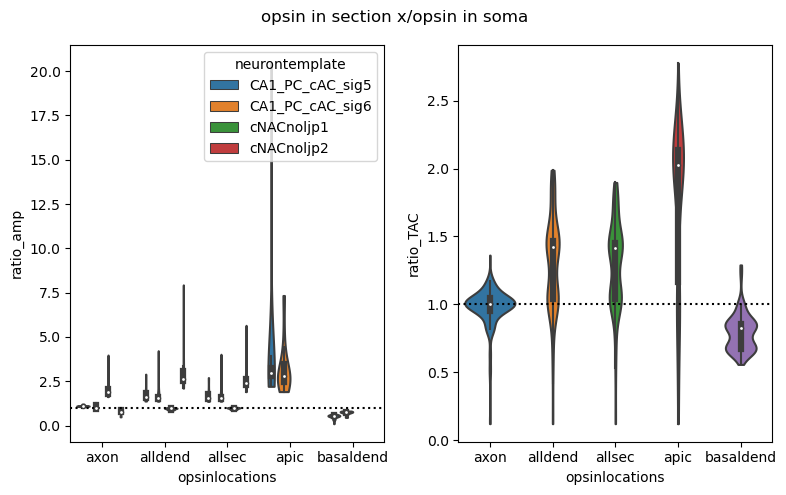

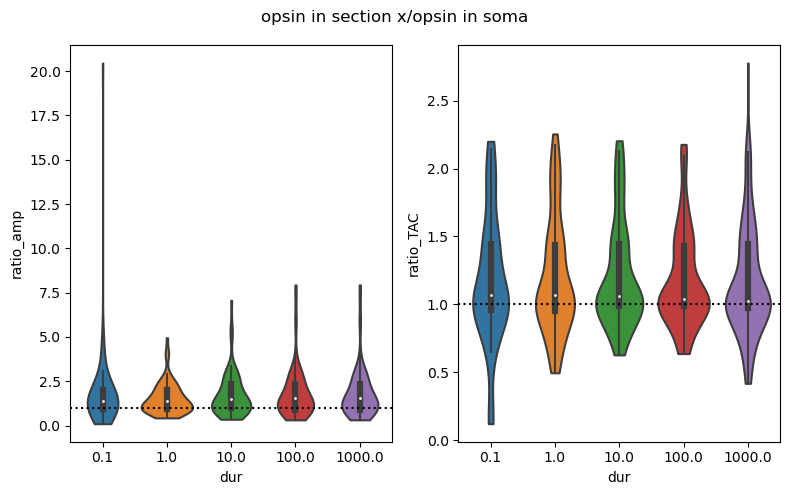

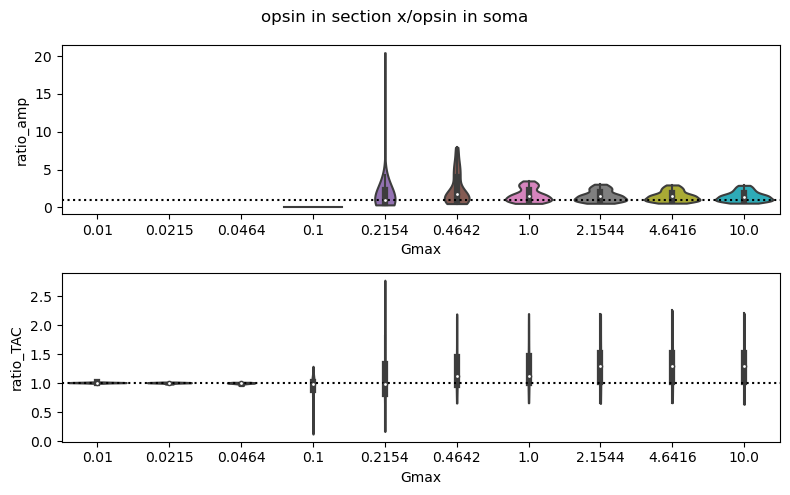

In [25]:
import seaborn as sns
fig,axs = plt.subplots(1,2,tight_layout = True,figsize=(8,5))

sns.violinplot(data=pyr_df,y='ratio_amp',x='opsinlocations',ax=axs[0],cut=0)
sns.violinplot(data=pyr_df,y='ratio_TAC',x='opsinlocations',ax=axs[1],cut=0)
for ax in axs:
    ax.axhline(1,color='k',linestyle=':')
fig.suptitle(f"{unique_values_columns_master['neurontemplate'][1]}/{unique_values_columns_master['neurontemplate'][0]}")

fig,axs = plt.subplots(1,2,tight_layout = True,figsize=(8,5))
sns.violinplot(data=pyr_df,y='ratio_amp',x='dur',ax=axs[0],cut=0)
sns.violinplot(data=pyr_df,y='ratio_TAC',x='dur',ax=axs[1],cut=0)
for ax in axs:
    ax.axhline(1,color='k',linestyle=':')
fig.suptitle(f"{unique_values_columns_master['neurontemplate'][1]}/{unique_values_columns_master['neurontemplate'][0]}")

fig,axs = plt.subplots(2,1,tight_layout = True,figsize=(8,5))
sns.violinplot(data=pyr_df,y='ratio_amp',x='Gmax',ax=axs[0],cut=0)
sns.violinplot(data=pyr_df,y='ratio_TAC',x='Gmax',ax=axs[1],cut=0)
for ax in axs:
    ax.axhline(1,color='k',linestyle=':')
fig.suptitle(f"{unique_values_columns_master['neurontemplate'][1]}/{unique_values_columns_master['neurontemplate'][0]}")

fig,axs = plt.subplots(1,2,tight_layout = True,figsize=(8,5))
sns.violinplot(data=rel_df,y='ratio_amp',x='opsinlocations',hue='neurontemplate',ax=axs[0],cut=0)
sns.violinplot(data=rel_df,y='ratio_TAC',x='opsinlocations',ax=axs[1],cut=0)
for ax in axs:
    ax.axhline(1,color='k',linestyle=':')
fig.suptitle(f"opsin in section x/opsin in soma")

fig,axs = plt.subplots(1,2,tight_layout = True,figsize=(8,5))
sns.violinplot(data=rel_df,y='ratio_amp',x='dur',ax=axs[0],cut=0)
sns.violinplot(data=rel_df,y='ratio_TAC',x='dur',ax=axs[1],cut=0)
for ax in axs:
    ax.axhline(1,color='k',linestyle=':')
fig.suptitle(f"opsin in section x/opsin in soma")

fig,axs = plt.subplots(2,1,tight_layout = True,figsize=(8,5))
sns.violinplot(data=rel_df,y='ratio_amp',x='Gmax',ax=axs[0],cut=0)
sns.violinplot(data=rel_df,y='ratio_TAC',x='Gmax',ax=axs[1],cut=0)
for ax in axs:
    ax.axhline(1,color='k',linestyle=':')
fig.suptitle(f"opsin in section x/opsin in soma")

,ratio_amp_mean,ratio_TAC_mean,ratio_gchr2_mean,ratio_amp_std,ratio_TAC_std,ratio_gchr2_std
opsinlocations,,,,,,
alldend,2.844653,1.397635,1.931265,1.467010,0.372179,0.550224
allsec,2.376125,1.333592,1.663435,0.907548,0.337094,0.527679
axon,0.357354,0.944507,0.164470,0.106021,0.523376,0.075300
soma,0.854519,0.937464,0.525020,0.116036,0.048687,0.150461


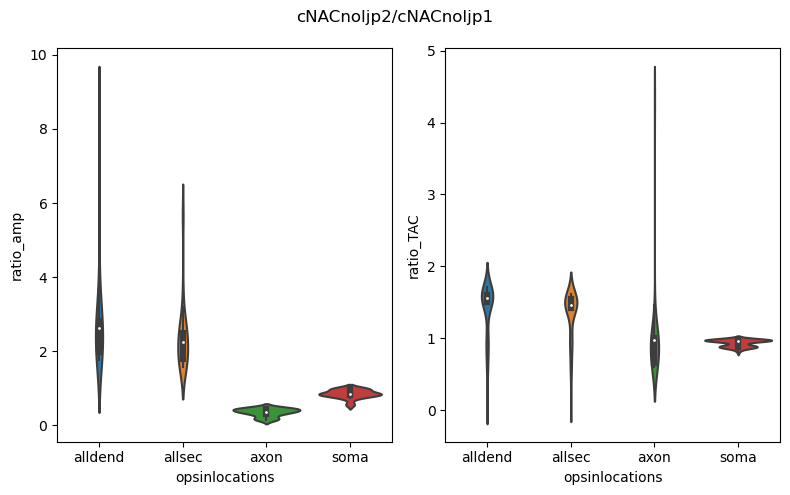

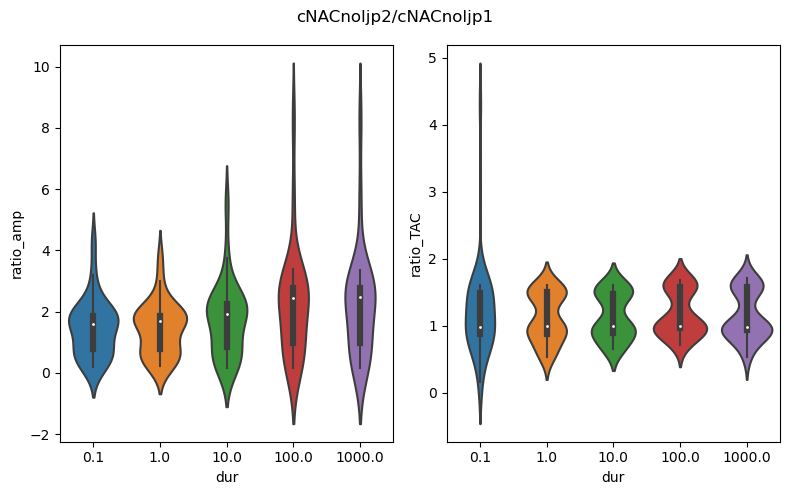

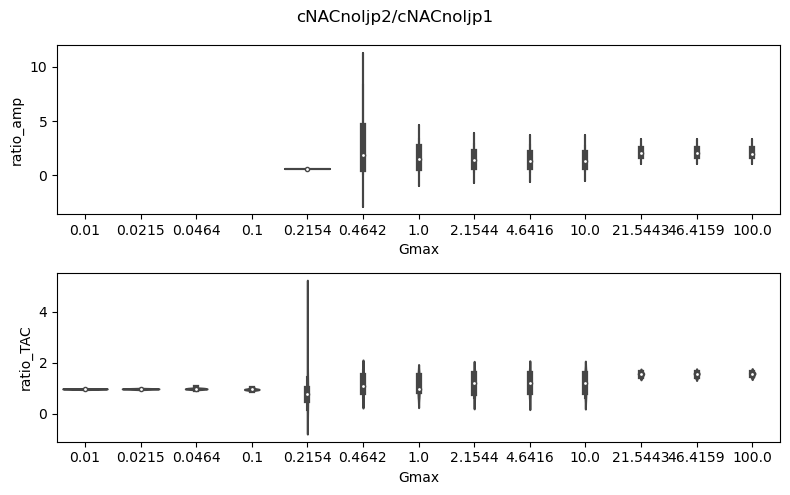

In [15]:
df1 = master_df[master_df['neurontemplate']==unique_values_columns_master['neurontemplate'][2]]
df2 = master_df[master_df['neurontemplate']==unique_values_columns_master['neurontemplate'][3]]
df1 = df1.set_index(['opsinlocations','dur','Gmax'])[['amp','sR','TAC','gchr2']]
df2 = df2.set_index(['opsinlocations','dur','Gmax'])[['amp','sR','TAC','gchr2']]
int_df = pd.merge(df1, df2, left_index=True, right_index=True, suffixes=('_0', '_1'))
for key in ['amp','TAC','gchr2']:
    #df3['diff_'+key] = df3[key+'_1']-df3[key+'_0']
    int_df['ratio_'+key] = int_df[key+'_1']/int_df[key+'_0']
int_df.reset_index(inplace=True)
columns = ['ratio_amp','ratio_TAC','ratio_gchr2']#['diff_amp','ratio_amp','diff_ichr2','ratio_ichr2','diff_gchr2','ratio_gchr2']
grouped = int_df.groupby('opsinlocations')[columns]
overall_int_df = pd.merge(grouped.mean(),grouped.std(),left_index=True, right_index=True, suffixes=('_mean', '_std'))

fig,axs = plt.subplots(1,2,tight_layout = True,figsize=(8,5))
sns.violinplot(data=int_df,y='ratio_amp',x='opsinlocations',ax=axs[0])
sns.violinplot(data=int_df,y='ratio_TAC',x='opsinlocations',ax=axs[1])
fig.suptitle(f"{unique_values_columns_master['neurontemplate'][3]}/{unique_values_columns_master['neurontemplate'][2]}")

fig,axs = plt.subplots(1,2,tight_layout = True,figsize=(8,5))
sns.violinplot(data=int_df,y='ratio_amp',x='dur',ax=axs[0])
sns.violinplot(data=int_df,y='ratio_TAC',x='dur',ax=axs[1])
fig.suptitle(f"{unique_values_columns_master['neurontemplate'][3]}/{unique_values_columns_master['neurontemplate'][2]}")

fig,axs = plt.subplots(2,1,tight_layout = True,figsize=(8,5))
sns.violinplot(data=int_df,y='ratio_amp',x='Gmax',ax=axs[0])
sns.violinplot(data=int_df,y='ratio_TAC',x='Gmax',ax=axs[1])
fig.suptitle(f"{unique_values_columns_master['neurontemplate'][3]}/{unique_values_columns_master['neurontemplate'][2]}")

overall_int_df

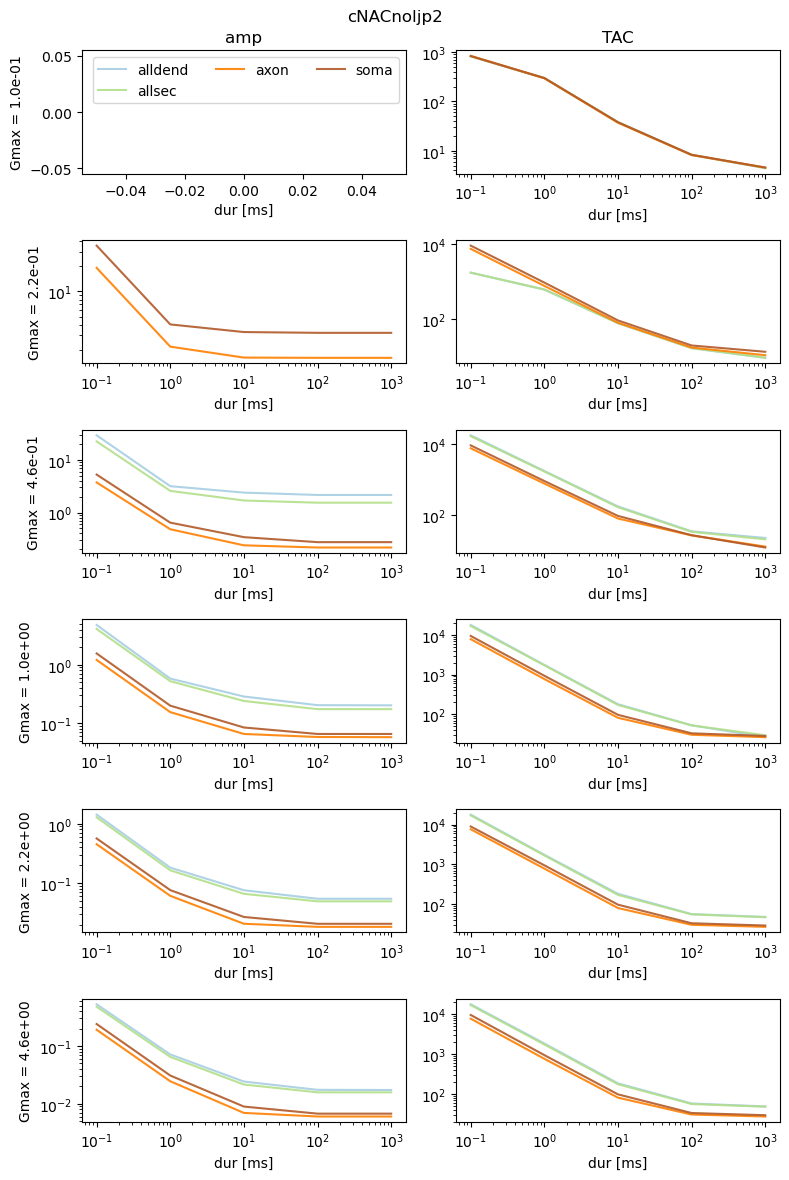

In [92]:
reference = ''
colors = plt.get_cmap('Paired',len(unique_values_columns_master['opsinlocations'])).colors
colorpairs = {x:clr for x,clr in zip(unique_values_columns_master['opsinlocations'],colors)}
linestyle_str = ['solid', 'dotted', 'dashed', 'dashdot']
uGmax = np.sort(master_df['Gmax'].unique())[3:-4]
fig,axs = plt.subplots(len(uGmax),2,tight_layout = True,figsize = (8,2*len(uGmax)))
for neurontemplate,linestyle in zip(unique_values_columns_master['neurontemplate'][3:],linestyle_str):
    fig_df = master_df[selection_generator(master_df,unique_values_columns=unique_values_columns_master,neurontemplate=neurontemplate)]
    uGmax = np.sort(fig_df['Gmax'].unique())[3:-4]
    for i,datalabel in enumerate(['amp','TAC']):
        for uG,ax in zip(uGmax,axs[:,i]):
            logscale = False
            intm_df = fig_df[fig_df['Gmax']==uG]
            uOpsinLocations = [x for x in intm_df['opsinlocations'].unique() if x != reference]
            for oL in uOpsinLocations:
                clr = colorpairs[oL]
                plot_df = intm_df[intm_df['opsinlocations']==oL]
                xdata = plot_df['dur']
                ydata = plot_df[datalabel]
                ref_ydata = intm_df[intm_df['opsinlocations']==reference][datalabel]
                ax.plot(xdata,ydata,color=clr,alpha=0.9,linestyle=linestyle,label=oL)
                if sum(~ np.isnan(ydata))>0:
                    logscale = True
            if logscale:
                ax.set_xscale('log')
                ax.set_yscale('log')
            ax.set_xlabel('dur [ms]')
            if i==0:
                ax.set_ylabel(f'Gmax = {uG:0.1e}')
            if uG == uGmax[0]:
                ax.set_title(datalabel)
                if i==0:
                    ax.legend(ncol=3)


    fig.suptitle(f'{neurontemplate}')
    print()

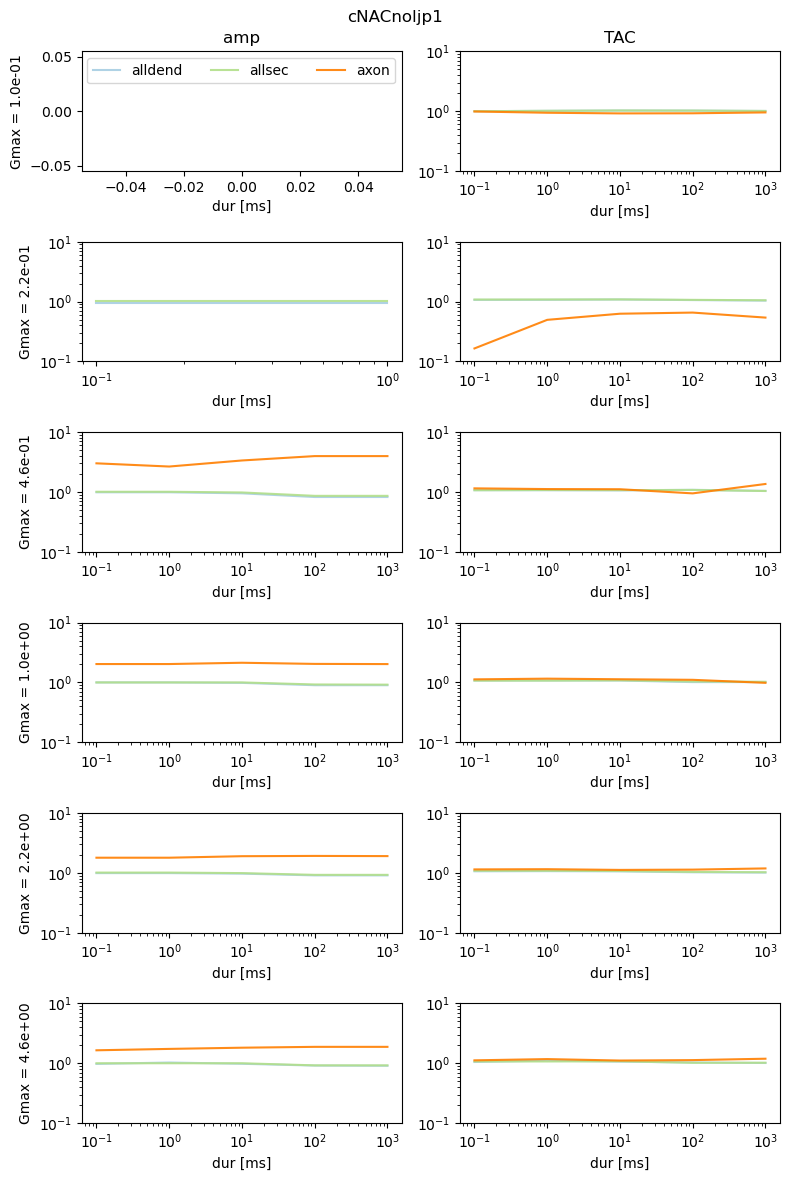

In [93]:
reference = 'soma'
colors = plt.get_cmap('Paired',len(unique_values_columns_master['opsinlocations'])).colors
colorpairs = {x:clr for x,clr in zip(unique_values_columns_master['opsinlocations'],colors)}
linestyle_str = ['solid', 'dotted', 'dashed', 'dashdot']
uGmax = np.sort(master_df['Gmax'].unique())[3:-4]
fig,axs = plt.subplots(len(uGmax),2,tight_layout = True,figsize = (8,2*len(uGmax)))
for neurontemplate,linestyle,alpha in zip(unique_values_columns_master['neurontemplate'][2:3],linestyle_str,[0.9,0.7]):
    fig_df = master_df[selection_generator(master_df,unique_values_columns=unique_values_columns_master,neurontemplate=neurontemplate)]


    for i,datalabel in enumerate(['amp','TAC']):
        for uG,ax in zip(uGmax,axs[:,i]):
            logscale = False
            intm_df = fig_df[fig_df['Gmax']==uG]
            uOpsinLocations = [x for x in intm_df['opsinlocations'].unique() if x != reference]
            for oL in uOpsinLocations:
                clr = colorpairs[oL]
                plot_df = intm_df[intm_df['opsinlocations']==oL]
                xdata = plot_df['dur']
                ydata = plot_df[datalabel]
                ref_ydata = intm_df[intm_df['opsinlocations']==reference][datalabel]
                if len(ydata)==len(ref_ydata):
                    ydata = np.array(ydata)/np.array(ref_ydata)
                    ax.plot(xdata,ydata,color=clr,alpha=alpha,linestyle=linestyle,label=oL)
                    if sum(~ np.isnan(ydata))>0:
                        logscale = True
            if logscale:
                ax.set_xscale('log')
                ax.set_yscale('log')
                ax.set_ylim([0.1,10])
            ax.set_xlabel('dur [ms]')
            if i==0:
                ax.set_ylabel(f'Gmax = {uG:0.1e}')
            if uG == uGmax[0]:
                ax.set_title(datalabel)
                if i==0:
                    ax.legend(ncol=3)


    fig.suptitle(f'{neurontemplate}')
    print()

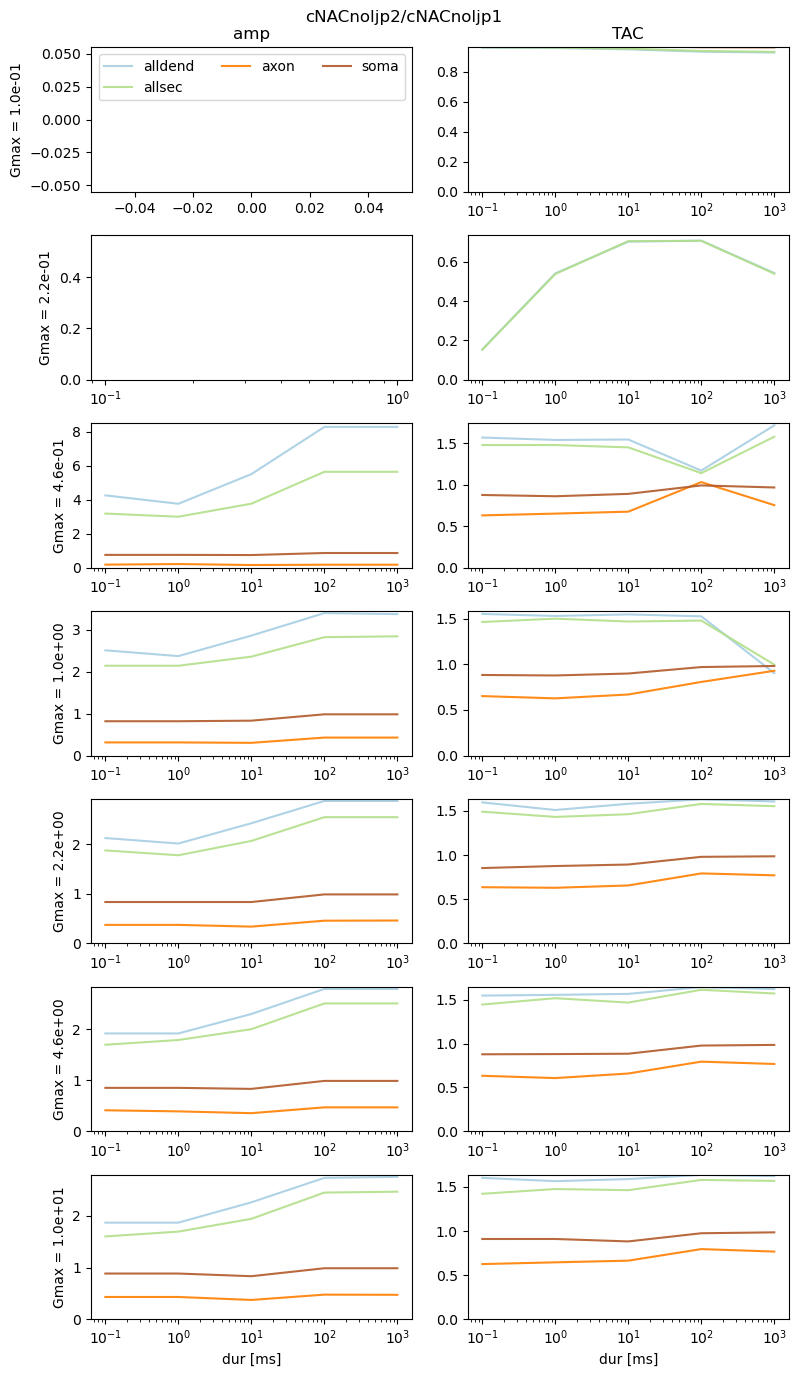

In [95]:
variables = unique_values_columns_master['neurontemplate'][2:4]
colors = plt.get_cmap('Paired',len(unique_values_columns_master['opsinlocations'])).colors
colorpairs = {x:clr for x,clr in zip(unique_values_columns_master['opsinlocations'],colors)}
linestyle_str = ['solid', 'dotted', 'dashed', 'dashdot']
uGmax = np.sort(master_df['Gmax'].unique())[3:-3]
fig,axs = plt.subplots(len(uGmax),2,tight_layout = True,figsize = (8,2*len(uGmax)))


cell_diff_dict = {}
uOpsinLocations = list(master_df[master_df['neurontemplate']==variables[1]]['opsinlocations'].unique())
cell_diff_dict['pyr'] = {key:{'amp':[],'TAC':[],'Gmax':[],'durs':[]} for key in uOpsinLocations}
for i,datalabel in enumerate(['amp','TAC']):
    uOpsinLocations = list(master_df[master_df['neurontemplate']==variables[1]]['opsinlocations'].unique())
    for oL in uOpsinLocations:
        for uG,ax in zip(uGmax,axs[:,i]):
            logscale = False
            intm_df = master_df[master_df['Gmax']==uG]

            clr = colorpairs[oL]
            plot_df = intm_df[intm_df['opsinlocations']==oL]
            xdata = plot_df['dur'][plot_df['neurontemplate']==variables[1]]
            ydata = plot_df[datalabel][plot_df['neurontemplate']==variables[1]]
            ref_ydata = plot_df[datalabel][plot_df['neurontemplate']==variables[0]]
            if len(ydata)==len(ref_ydata):
                ydata = np.array(ydata)/np.array(ref_ydata)
                ax.plot(xdata,ydata,color=clr,alpha=0.9,label=oL)
                if sum(~ np.isnan(ydata))>0:
                    logscale = True
            if logscale:
                ax.set_xscale('log')
                #ax.set_yscale('log')
                ax.set_ylim([0,ax.get_ylim()[1]])
            if i==0:
                ax.set_ylabel(f'Gmax = {uG:0.1e}')
            if uG == uGmax[0]:
                ax.set_title(datalabel)
                if i==0:
                    ax.legend(ncol=3)
        ax.set_xlabel('dur [ms]')


    fig.suptitle(f'{variables[1]}/{variables[0]}')
    print()